## Question Number 3

The question:
> Can you build an Artificial Neural Network (ANN) model to categorize the alcohol molecule given readings from the electronic nose? (Please consider the MIP:NP ratio as one of the features as well) Please justify your choice of algorithm and walk us through your logic as you develop the model. What is the accuracy, precision, and recall of the model?

This notebook will be almost the same as the notebook for question no. 2 as it's pretty much the same problem tackled using different methods (non-ANN model previously while here we're focusing on ANN). So the outline of the notebook will be almost exactly the same.

## Importing modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras

2023-09-06 21:58:44.412809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Datasets

In [2]:
qcm3_df = pd.read_csv('./dataset/QCM3.csv', delimiter=';')
qcm6_df = pd.read_csv('./dataset/QCM6.csv', delimiter=';')
qcm7_df = pd.read_csv('./dataset/QCM7.csv', delimiter=';')
qcm10_df = pd.read_csv('./dataset/QCM10.csv', delimiter=';')
qcm12_df = pd.read_csv('./dataset/QCM12.csv', delimiter=';')

DFs = {
    'QCM3': qcm3_df,
    'QCM6': qcm6_df,
    'QCM7': qcm7_df,
    'QCM10': qcm10_df,
    'QCM12': qcm12_df,
}

## Collapsing dataframe

In [3]:
def collapse_df(df: pd.DataFrame) -> pd.DataFrame:
    new_data = {
        'MIP': [],
        'NP': [],
        'ratio': []
    }
    for alcohol in df.columns[-5:]:
        new_data[alcohol] = []

    for l in range(5):
        df_l = df.loc[df[df.columns[-5+l]] == 1]
        np_l = df_l.to_numpy()
        for c in range(5):
            new_data['MIP'].extend(np_l[:, 2*c].tolist())
            new_data['NP'].extend(np_l[:, 2*c+1].tolist())
            new_data['ratio'].extend((np_l[:, 2*c]/np_l[:, 2*c+1]).tolist())

            alc_i = -5
            for alcohol in df.columns[-5:]:
                new_data[alcohol].extend(np_l[:, alc_i].tolist())
                alc_i += 1
    new_df = pd.DataFrame(new_data)
    return new_df


Same reason to collapse the datasets as the previous notebook.

In [4]:
DFs['QCM3'].loc[:1, :]

,0.799_0.201_MIP,0.799_0.201_NP,0.700_0.300_MIP,0.700_0.300_NP,0.600_0.400_MIP,0.600_0.400_NP,0.501_0.499_MIP,0.501_0.499_NP,0.400_0.600_MIP,0.400_0.600_NP,1-Octanol,1-Propanol,2-Butanol,2-propanol,1-isobutanol
0,-10.06,-10.62,-14.43,-18.31,-24.64,-30.56,-38.62,-45.59,-54.89,-62.28,1,0,0,0,0
1,-9.69,-10.86,-16.73,-21.75,-28.47,-35.83,-43.65,-52.43,-61.92,-71.27,1,0,0,0,0


In [5]:
collapse_df(DFs['QCM3'].loc[:1, :])

,MIP,NP,ratio,1-Octanol,1-Propanol,2-Butanol,2-propanol,1-isobutanol
0,-10.06,-10.62,0.947269,1.0,0.0,0.0,0.0,0.0
1,-9.69,-10.86,0.892265,1.0,0.0,0.0,0.0,0.0
2,-14.43,-18.31,0.788094,1.0,0.0,0.0,0.0,0.0
3,-16.73,-21.75,0.769195,1.0,0.0,0.0,0.0,0.0
4,-24.64,-30.56,0.806283,1.0,0.0,0.0,0.0,0.0
5,-28.47,-35.83,0.794586,1.0,0.0,0.0,0.0,0.0
6,-38.62,-45.59,0.847116,1.0,0.0,0.0,0.0,0.0
7,-43.65,-52.43,0.832539,1.0,0.0,0.0,0.0,0.0
8,-54.89,-62.28,0.881342,1.0,0.0,0.0,0.0,0.0
9,-61.92,-71.27,0.868809,1.0,0.0,0.0,0.0,0.0


Above is the example of the result of `collapse_df` functions, along with collapsing MIP and NP columns we also calculate the ratio of MIP/NP which could be useful as additional feature for our models.

## Train/Test Split

In [6]:
def test_train_split(df: pd.DataFrame, test_frac: float=.4, labels_start_index: int=-5):
    N_total = df.shape[0]
    test_indexes = []
    for c in range(abs(labels_start_index)):
        # proportion = df[df[df.columns[-5]] == 1].shape[0]/N_total
        test_indexes.extend(
                df[df[df.columns[labels_start_index+c]] == 1]
                .sample(frac=test_frac).index.to_list()
            )
    train_df = df.drop(index=test_indexes)
    test_df = df.iloc[test_indexes]
    
    return train_df, test_df
    

Since the datasets that we have are as balanced as it can be (5 categories with 20% proportion for each category). We need a way to keep those proportions when we split the datasets to train and test data. The functions above made sure that each category keeps its 20% proportion even after being split into train and test.

In [7]:
def get_proportions(df: pd.DataFrame):
    N_total = df.shape[0]
    for c in df.columns[-5:]:
        c_count = df.loc[df[c] == 1].shape[0]
        percentage = 100 * c_count/N_total
        print (f"  {c}\t: {percentage:4.1f}% ({c_count}/{N_total})")


_train, _test = test_train_split(collapse_df(DFs['QCM3']))

print("Proportion of train data")
get_proportions(_train)

print("\nProportion of train data")
get_proportions(_test)

Proportion of train data
  1-Octanol	: 20.0% (15/75)
  1-Propanol	: 20.0% (15/75)
  2-Butanol	: 20.0% (15/75)
  2-propanol	: 20.0% (15/75)
  1-isobutanol	: 20.0% (15/75)

Proportion of train data
  1-Octanol	: 20.0% (10/50)
  1-Propanol	: 20.0% (10/50)
  2-Butanol	: 20.0% (10/50)
  2-propanol	: 20.0% (10/50)
  1-isobutanol	: 20.0% (10/50)


As can be seen above, the proportion is consistent even after train/test split.

## Training

So let's talk about the difference in trainig procedure here compared to the prevous one.

Below is the function that will process our data from the beginning, doing the train-test split, training the model, and finally calculating the metrics on test data.

For features, by default MIP and NP readings will be included. I added option to include `ratio` (MIP/NP) as additional feature so we can compare it later. The fractional split for test and train data is 60% training data and 40% test data, I choose that ratio because for our data that is multiples of 5, 60% to 40% split nicely into 3/5 and 2/5 of the training data.

The train-test split is randomize so each runs might produce different metrics, hence why we will run this process for each models (and features) configurations several times and then average the results for comparison.

In [8]:
def one_hot(x, num_categories=5):
    one_hot_matrix = np.eye(num_categories)
    one_hot_encoded_data = one_hot_matrix[x.ravel()]
    return one_hot_encoded_data

def train(model, df: pd.DataFrame, include_ratio: bool=True, average="micro", 
          use_integer_label=False, epochs: int=100): 
    train_df, test_df = test_train_split(collapse_df(df))
    
    feature_split_index = 3 if include_ratio else 2
    X_train = train_df.to_numpy()[:, :feature_split_index]
    y_train = train_df.to_numpy()[:, -5:]

    X_test = test_df.to_numpy()[:, :feature_split_index]
    y_test = test_df.to_numpy()[:, -5:]

    if (use_integer_label):
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train)

    print('begin training')
    model.fit(scaler.transform(X_train), y_train, epochs=epochs)
    
    train_pred = model.predict(scaler.transform(X_train))
    train_pred = np.argmax(train_pred, axis=1)
    if (use_integer_label):
        yt_oh = one_hot(y_train, num_categories=5)
        pred_oh = one_hot(train_pred, num_categories=5)
        print(f'train acc       -> {100*accuracy_score(yt_oh, pred_oh):5.3f}%')
        print(f'train precision -> {100*precision_score(yt_oh, pred_oh, average=average):5.3f}%')
        print(f'train recall    -> {100*recall_score(yt_oh, pred_oh, average=average):5.3f}%')
    else:
        print(f'train acc       -> {100*accuracy_score(y_train, train_pred):5.3f}%')
        print(f'train precision -> {100*precision_score(y_train, train_pred, average=average):5.3f}%')
        print(f'train recall    -> {100*recall_score(y_train, train_pred, average=average):5.3f}%')

    print('\nbegin testing')
    metrics = {}
    y_pred = model.predict(scaler.transform(X_test))
    y_pred = np.argmax(y_pred, axis=1)

    if (use_integer_label):
        yt_oh = one_hot(y_test, num_categories=5)
        pred_oh = one_hot(y_pred, num_categories=5)
        metrics['accuracy'] = accuracy_score(yt_oh, pred_oh)
        metrics['precision'] = precision_score(yt_oh, pred_oh, average=average)
        metrics['recall'] = recall_score(yt_oh, pred_oh, average=average)
    else:
        metrics['accuracy'] = accuracy_score(y_test, y_pred)
        metrics['precision'] = precision_score(y_test, y_pred, average=average)
        metrics['recall'] = recall_score(y_test, y_pred, average=average)
    
    print('finished training session')
    return metrics, X_train, y_train, X_test, y_test



Here is the function that will called the previous `train` functions several times as specified by `trial_counts` parameter. Keep in mind that this function only runs for one model and one datasets (we have 5 different QCM readings). As said previously, the resulting metrics then averaged so we can get more consistent value.

The choice of 21 for `trial_counts` is arbitrary as I see at that number the results became quite consistent.

In [9]:
def train_model(model_builder, df: pd.DataFrame, trial_counts:int=6, 
                include_ratio=True, use_integer_label=False, epochs: int=100,
                average='macro'):
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(trial_counts):
        print(f"Begin itteration {i+1}")
        model = model_builder()
        _metrics, _, _, _, _ = train(model, df, average=average, 
                                     use_integer_label=use_integer_label,
                                     include_ratio=include_ratio,
                                     epochs=epochs
                                     )

        print(f"metrics trials {i+1}: {_metrics}\n")

        metrics['accuracy'].append(_metrics['accuracy'])
        metrics['precision'].append(_metrics['precision'])
        metrics['recall'].append(_metrics['recall'])

    for key in metrics.keys():
        metrics[key] = np.mean(metrics[key])

    print(f'\nAverage metrics for {trial_counts} trials:\n\t{metrics}')
    return metrics

And finally this is the function that will run all 5 datasets to one model, here I'm using `model_builder` function to create the model before every trials. 

In [10]:
def get_metrics_for_model(
        model_builder, include_ratio=True, use_integer_label=False,
        epochs: int=100, trial_counts = 1, average='micro'
        ):
    metrics = {
        'sensor': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    for key in DFs.keys():
        _metrics = train_model(
            model_builder, DFs[key], include_ratio=include_ratio, 
            use_integer_label=use_integer_label,
            epochs=epochs, trial_counts=trial_counts,
            average=average
            )
        metrics['sensor'].append(key)
        for mKey in _metrics.keys():
            metrics[mKey].append(_metrics[mKey])

    print("Everything is finished")
    return metrics

The functions below are just utility functions to show and visualize resulting metrics gathered from training process.

In [11]:
def plot_metrics(metrics, model_name: str=''):
    width = 0.25

    ind = np.arange(len(metrics['sensor']))

    figs = []
    metric_names = list(metrics.keys())[1:]
    for i, m in enumerate(metric_names):
        
        fig = plt.bar(ind+i*width, metrics[m], width, edgecolor='black')
        figs.append(fig)

    plt.legend(figs, metric_names, loc='lower right')

    plt.xticks(ind+width, metrics['sensor'])
    plt.xlabel('Sensor Type')
    plt.ylabel('Accuracy (%)')

    plt.ylim(0, 1)
    plt.title(', '.join(['Accuracy for each sensors', model_name]))

    plt.grid()
    plt.show()

def plot_metrics_comp(packed_metrics: list, model_name: str=''):
    width = 0.25

    metrics_w, metrics_wo = packed_metrics
    ind = np.arange(len(metrics_w['sensor']))

    color_dict = {
        'accuracy': 'red',
        'precision': 'black',
        'recall': 'grey',
    }
    figs = []
    metric_names = list(metrics_w.keys())[1:]
    for i, m in enumerate(metric_names):
        
        fig = plt.bar(ind+i*width, metrics_w[m], width/2, color=color_dict[m], edgecolor='black')
        fig = plt.bar(ind+i*width+width/2, metrics_wo[m], width/2, color=color_dict[m], edgecolor='black')
        figs.append(fig)

    plt.legend(figs, metric_names, loc='lower right')

    plt.xticks(ind+width, metrics_w['sensor'])
    plt.xlabel('Sensor Type')
    plt.ylabel('Accuracy (%)')

    plt.ylim(0, 1)
    plt.title(', '.join(['Accuracy for each sensors', model_name]))

    plt.grid()
    plt.gcf().set_figwidth(15)
    plt.show()

In [12]:
def show_model_metrics(packed_metrics: list):
    metrics_w_ratio, metrics_wo_ratio = packed_metrics
    metrics_df = pd.DataFrame(metrics_w_ratio)
    metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics_wo_ratio).drop(columns=['sensor'])], axis=1)

    with_ratio_col = 'With MIP/NP Ratio'
    without_ratio_col = 'Without MIP/NP Ratio'
    metrics_df.columns = pd.MultiIndex.from_tuples(
        [
            ('sensor', 'type'),
            (with_ratio_col, 'accuracy'),
            (with_ratio_col, 'precision'),
            (with_ratio_col, 'recall'),
            (without_ratio_col, 'accuracy'),
            (without_ratio_col, 'precision'),
            (without_ratio_col, 'recall'),
        ]
    )

    display(metrics_df)

## Artificial Neural Network Training

If I have more times I might be able to implement hyperparameters tuning using keras tuner, but even searching the following configuration for ANN models is already quite demanding for my devices. Hyperparameter tuning will takes a lot more time and a longer slow down time for my laptop. Hence, I'll only train one model configuration that is one with 3 Hidden Layers, each have 128, 256, and 128 neurons from front to the back, each have Rectified Linear Units (ReLU) as their activation function.

For each datasets (which we have 5), the models will be trained 3 times, with different train-test split each times. This hopefully will ensure that the result we get is consistent and not just a fluke of random nature of artificial neural networks.

The choice like number of layers, number of neurons, and epochs here were manually made by me by searching which one gave the best metrics.

In [13]:
def ann_builder():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model


metrics_w_ratio = get_metrics_for_model(
    ann_builder, include_ratio=True, use_integer_label=True, average='macro', epochs=300, trial_counts=3)
metrics_wo_ratio = get_metrics_for_model(
    ann_builder, include_ratio=False, use_integer_label=True, average='macro', epochs=300, trial_counts=3)
ann_metrics = [metrics_w_ratio, metrics_wo_ratio]

Begin itteration 1
begin training


2023-09-06 21:58:49.026383: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/300
3/3 [==============================] - 3s 32ms/step - loss: 1.6075 - accuracy: 0.2400
Epoch 2/300
3/3 [==============================] - 0s 12ms/step - loss: 1.5507 - accuracy: 0.4000
Epoch 3/300
3/3 [==============================] - 0s 11ms/step - loss: 1.4990 - accuracy: 0.4000
Epoch 4/300
3/3 [==============================] - 0s 10ms/step - loss: 1.4489 - accuracy: 0.4000
Epoch 5/300
3/3 [==============================] - 0s 17ms/step - loss: 1.3990 - accuracy: 0.4000
Epoch 6/300
3/3 [==============================] - 0s 66ms/step - loss: 1.3508 - accuracy: 0.4000
Epoch 7/300
3/3 [==============================] - 0s 8ms/step - loss: 1.2959 - accuracy: 0.4000
Epoch 8/300
3/3 [==============================] - 0s 35ms/step - loss: 1.2433 - accuracy: 0.4000
Epoch 9/300
3/3 [==============================] - 0s 36ms/step - loss: 1.1960 - accuracy: 0.4267
Epoch 10/300
3/3 [==============================] - 0s 11ms/step - loss: 1.1469 - accuracy: 0.4400
Epoch 11/300
3/3 [==

In [15]:
show_model_metrics(ann_metrics)

sensor With MIP/NP Ratio                     Without MIP/NP Ratio            \
    type          accuracy precision    recall             accuracy precision   
0   QCM3          0.840000  0.870997  0.840000             0.820000  0.849863   
1   QCM6          0.680000  0.689615  0.680000             0.733333  0.749986   
2   QCM7          0.740000  0.760945  0.740000             0.693333  0.705269   
3  QCM10          0.940000  0.946652  0.940000             0.786667  0.809369   
4  QCM12          0.793333  0.820982  0.793333             0.813333  0.830349   

             
     recall  
0  0.820000  
1  0.733333  
2  0.693333  
3  0.786667  
4  0.813333

From the result above we can see that the best performing model is the model with `MIP/NP ratio` paired with `QCM10` sensor.

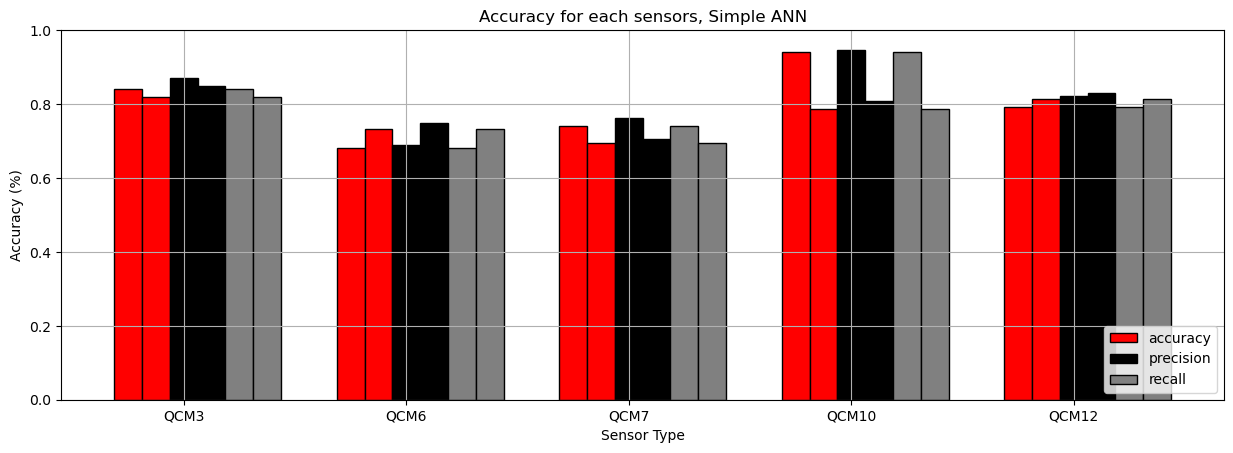

In [16]:
plot_metrics_comp(ann_metrics, model_name='Simple ANN')

## Conclusion

From graphs and table above we can conclude that the best sensor is `QCM10` paired with random forest model _with_ `MIP/NP ratio` as feature with the following metrics:

In [19]:
m = 0
for key in ann_metrics[m].keys():
    if key == 'sensor':
        print (f'{key.capitalize():<10}   : {ann_metrics[m][key][3]:>6}')
        continue    
    print (f'{key.capitalize():<10}   : {100*ann_metrics[m][key][3]:5.2f}%')

Sensor       :  QCM10
Accuracy     : 94.00%
Precision    : 94.67%
Recall       : 94.00%
